In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import cbook
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns

import struct
import zlib
import sys
import random

from PIL import Image
import numpy as np

sns.set({'grid.linewidth': '10'}, style="white")
width = 400
height = 296
colormode = 3
colordepth = 8

def clamp(n, smallest, largest):
    return max(smallest, min(n, largest))

In [2]:
# original palette, https://lospec.com/palette-list/citrink
palette_hex = ['201533',
               '252446',
               '254d70',
               '166e7a',
               '52c33f',
               'b2d942',
               'fcf660',
               'ffffff']

# derived from hex values, RGB, normalized
palette = [(0.12549019607843137, 0.08235294117647059, 0.2),
            (0.1450980392156863, 0.1411764705882353, 0.27450980392156865),
            (0.1450980392156863, 0.30196078431372547, 0.4392156862745098),
            (0.08627450980392157, 0.43137254901960786, 0.47843137254901963),
            (0.3215686274509804, 0.7647058823529411, 0.24705882352941178),
            (0.6980392156862745, 0.8509803921568627, 0.25882352941176473),
            (0.9882352941176471, 0.9647058823529412, 0.3764705882352941),
            (1.0, 1.0, 1.0)]

In [3]:
# load PNGs
rawbuf_flower = np.clip(np.reshape(np.array(Image.open('flower.png').getdata()), (296, 400)), 0, 255)
rawbuf_mta = np.clip(np.reshape(np.array(Image.open('mta.png').getdata()), (296, 400)), 0, 255)

In [4]:
# inflate 8 color palette to 256 entries, 8x32 entries
def noDitherPalette(pal):
    colors = []
    pallen = int(256/len(pal))
    for p in pal:
        for _ in range(pallen):
            colors.append(p)
    return colors

In [5]:
# inflate 8 color palette to 256 entries, 8x32 entries
# apply random noise, randomly choose palette color above or below current
def ditherPaletteRandom(pal, factor):
    colors = []
    pallen = int(256/len(pal))
    for k, p in enumerate(pal):
        for l in range(pallen):
            random.seed(k*l*23/17)
            r = int(random.randint(-factor, factor)/factor)
            if k == 0:
                if r == -1:
                    r = 0
            if k == len(pal)-1:
                if r == 1:
                    r = 0
            p = pal[k+r]
            colors.append(p)
    return colors

In [6]:
# inflate 8 color palette to 256 entries, 8x32 entries
# apply ordered pattern to color transitions
def ditherPaletteOrderedA(pal, pattern):
    colors = []
    pallen = int(256/len(pal))
    
    # standard palette inflation
    for k, p in enumerate(pal):
        for l in range(pallen):
            colors.append(p)
    
    # jump to transitions, and apply pattern above and below
    for k in range(0, len(pal)):
        for pat in pattern:
            p = pal[clamp(k-clamp(pat, 0, 1),0,len(pal))]
            colors[clamp(k*pallen+pat, 0, 255)] = p

    return colors

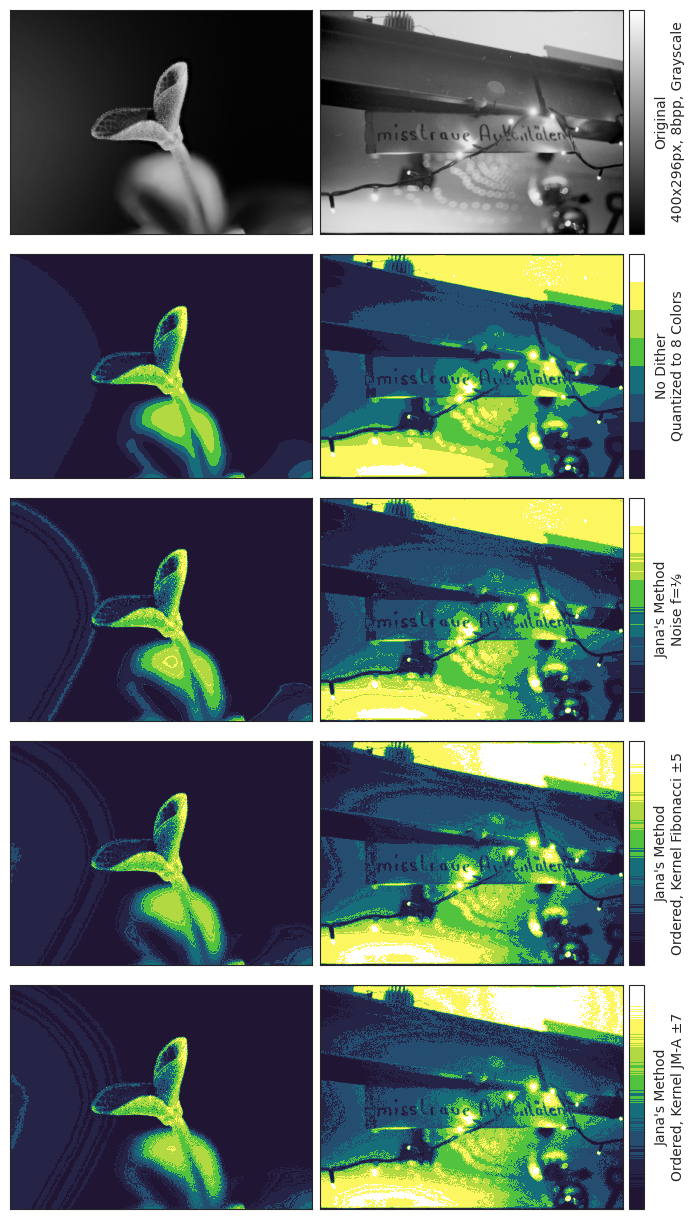

In [7]:
# do touch
cmap = ['gray',
        colors.ListedColormap(noDitherPalette(palette)),
        #colors.ListedColormap(ditherPaletteRandom(palette, 5)),
        colors.ListedColormap(ditherPaletteRandom(palette, 9)),
        #colors.ListedColormap(ditherPaletteOrderedA(palette, [-7, -5, -4, 4, 5, 7])),
        colors.ListedColormap(ditherPaletteOrderedA(palette, [-5, -3, -2, -1, 0, 1, 2, 3, 5])),
        colors.ListedColormap(ditherPaletteOrderedA(palette, [-7, -4, -2, -1, 0, 1, 2, 4, 7])),
        #colors.ListedColormap(ditherPaletteOrderedA(palette, [-34, -21, -13, -8, -5, -3, -2, -1, 0, 1, 2, 3, 5, 8, 13, 21, 34]))
        ]

plot_titles = ['Original\n400x296px, 8bpp, Grayscale',
               'No Dither\nQuantized to 8 Colors',
               #'Jana\'s Random f=5',
               'Jana\'s Method\nNoise f=⅑',
               #'Jana\'s Ordered A',
               'Jana\'s Method\nOrdered, Kernel Fibonacci ±5',
               'Jana\'s Method\nOrdered, Kernel JM-A ±7',
               #'Jana\'s Fibonacci L'
                ]

# do not touch
rows = len(cmap)
image_data = [rawbuf_flower, rawbuf_mta]

# set up grid
fig = plt.figure(figsize=(18., 18.))
grid = AxesGrid(fig, 122,
                    nrows_ncols=(rows, 2),
                    axes_pad=(0.08,0.2),
                    label_mode="1",
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="edge",
                    cbar_size="5%",
                    cbar_pad="2%",
                    )

# charts, colorbars and titles
for i, cax in enumerate(grid.cbar_axes):
    im = grid[i].imshow(image_data[i%2], cmap=cmap[i//2], vmin=0, vmax=255)
    if i % 2:
        grid.cbar_axes[i//2].colorbar(im, ticks=[])
        grid.cbar_axes[i//2].tick_params(labelsize=8)
        grid.cbar_axes[i//2].axis[cax.orientation].set_label(plot_titles[i//2])

# turn ticks/grid off
grid.axes_llc.set_xticks([])
grid.axes_llc.set_yticks([])

#plt.show()
plt.savefig('out.png', transparent=None, dpi=420, bbox_inches='tight')

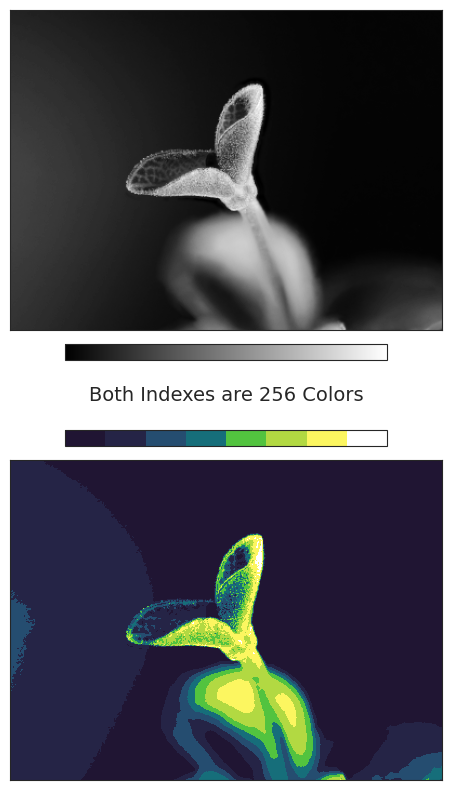

In [81]:
image_data = rawbuf_flower
sh=0.4

fig = plt.figure(figsize=(10., 10.))

plt.subplot(2, 1, 1)
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
imgplot1 = plt.imshow(image_data, cmap='gray')
plt.colorbar(location='bottom', fraction=0.046, pad=0.04, ticks=[])

plt.subplot(2, 1, 2)
plt.title('Both Indexes are 256 Colors', y=1.16, size=14)
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
imgplot2 = plt.imshow(image_data, cmap=colors.ListedColormap(noDitherPalette(palette)))
plt.colorbar(location='top', fraction=0.046, pad=0.04, ticks=[])

#plt.show()
plt.savefig('gayscale-to-index.png', transparent=None, dpi=420, bbox_inches='tight')

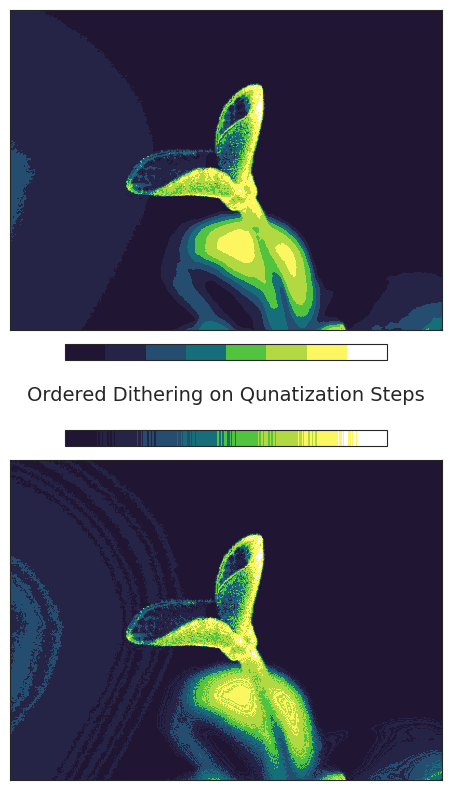

In [87]:
image_data = rawbuf_flower
sh=0.4

fig = plt.figure(figsize=(10., 10.))

plt.subplot(2, 1, 1)
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
imgplot1 = plt.imshow(image_data, cmap=colors.ListedColormap(noDitherPalette(palette)))
plt.colorbar(location='bottom', fraction=0.046, pad=0.04, ticks=[])

plt.subplot(2, 1, 2)
plt.title('Ordered Dithering on Qunatization Steps', y=1.16, size=14)
plt.tick_params(
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)
imgplot2 = plt.imshow(image_data, cmap=colors.ListedColormap(ditherPaletteOrderedA(palette, [-7, -4, -2, -1, 0, 1, 2, 4, 7])))
plt.colorbar(location='top', fraction=0.046, pad=0.04, ticks=[])

#plt.show()
plt.savefig('index-to-dither-index.png', transparent=None, dpi=420, bbox_inches='tight')